### Importation de Bibliothèque

In [1]:
#os libraries
import os 
import itertools 
from PIL import Image
# data handling libraries 
import cv2 
import pandas as pd 
import numpy as np 
import seaborn as sns 
import matplotlib.pyplot as plt 
from sklearn.model_selection import train_test_split 
from sklearn.metrics import confusion_matrix,classification_report 
#deep learning libraries 
import tensorflow as tf
from tensorflow import keras 
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam ,Adamax
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D,MaxPooling2D,Flatten,Dense,Dropout,BatchNormalization
from tensorflow.keras import regularizers
import warnings 
warnings.filterwarnings('ignore')

### Pretraitement de Données

In [2]:
# train/positif/gg
train_data_dir = 'Training'
filepaths = []
labels = []

folds = os.listdir(train_data_dir)
for fold in folds:
    foldpath = os.path.join(train_data_dir, fold)
    filelist = os.listdir(foldpath)
    for file in filelist:
        fpath = os.path.join(foldpath, file)
        filepaths.append(fpath)
        labels.append(fold)
Fseries = pd.Series(filepaths, name= 'filepaths')
Lseries = pd.Series(labels, name='labels')
data = pd.concat([Fseries, Lseries], axis= 1)
data.head()

,filepaths,labels
0,Training\benigne\TCGA_CS_4944_20010208_15.tif,benigne
1,Training\benigne\TCGA_CS_4944_20010208_16.tif,benigne
2,Training\benigne\TCGA_CS_4944_20010208_17.tif,benigne
3,Training\benigne\TCGA_CS_4944_20010208_18.tif,benigne
4,Training\benigne\TCGA_CS_4944_20010208_19.tif,benigne


In [4]:
test_data_dir = 'Testing' 
filepaths = []
labels = []
folds = os.listdir(test_data_dir)

for fold in folds:
    foldpath = os.path.join(test_data_dir,fold)
    filelist = os.listdir(foldpath) 
    for file in filelist:
        fpath = os.path.join(foldpath,file)
        filepaths.append (fpath)
        labels.append(fold)
Fseries = pd.Series(filepaths,name = 'filepaths')
Lseries = pd.Series(labels, name = 'labels')
dt = pd.concat([Fseries,Lseries],axis='columns')
dt.head() 

,filepaths,labels
0,Testing\benigne\TCGA_CS_4941_19960909_1.tif,benigne
1,Testing\benigne\TCGA_CS_4941_19960909_10.tif,benigne
2,Testing\benigne\TCGA_CS_4941_19960909_19.tif,benigne
3,Testing\benigne\TCGA_CS_4941_19960909_2.tif,benigne
4,Testing\benigne\TCGA_CS_4941_19960909_20.tif,benigne


### Split de notre dataset en Train , valid , test 

In [5]:
valid_df,test_df = train_test_split(dt,train_size=0.5,shuffle=True,random_state=123)

### Image data generator

In [6]:
batch_size=16
img_size = (224,224)
channels = 3 
img_shape=(img_size[0],img_size[1],channels)  #224*224*3
tr_gen = ImageDataGenerator()
ts_gen = ImageDataGenerator()
train_gen = tr_gen.flow_from_dataframe(data, x_col= 'filepaths', y_col= 'labels',
                                       target_size= img_size, 
                                       class_mode= 'categorical', 
                                       color_mode= 'rgb', 
                                       shuffle= True,
                                       batch_size= batch_size)
test_gen = tr_gen.flow_from_dataframe(test_df, x_col= 'filepaths', 
                                      y_col= 'labels',
                                      target_size= img_size, 
                                      class_mode= 'categorical', 
                                      color_mode= 'rgb', 
                                      shuffle= False,
                                      batch_size= batch_size)

valid_gen = tr_gen.flow_from_dataframe(valid_df, x_col= 'filepaths', 
                                       y_col= 'labels', 
                                       target_size= img_size, 
                                       class_mode= 'categorical', 
                                       color_mode= 'rgb', 
                                       shuffle= True,
                                       batch_size= batch_size)

Found 3144 validated image filenames belonging to 2 classes.
Found 393 validated image filenames belonging to 2 classes.
Found 392 validated image filenames belonging to 2 classes.


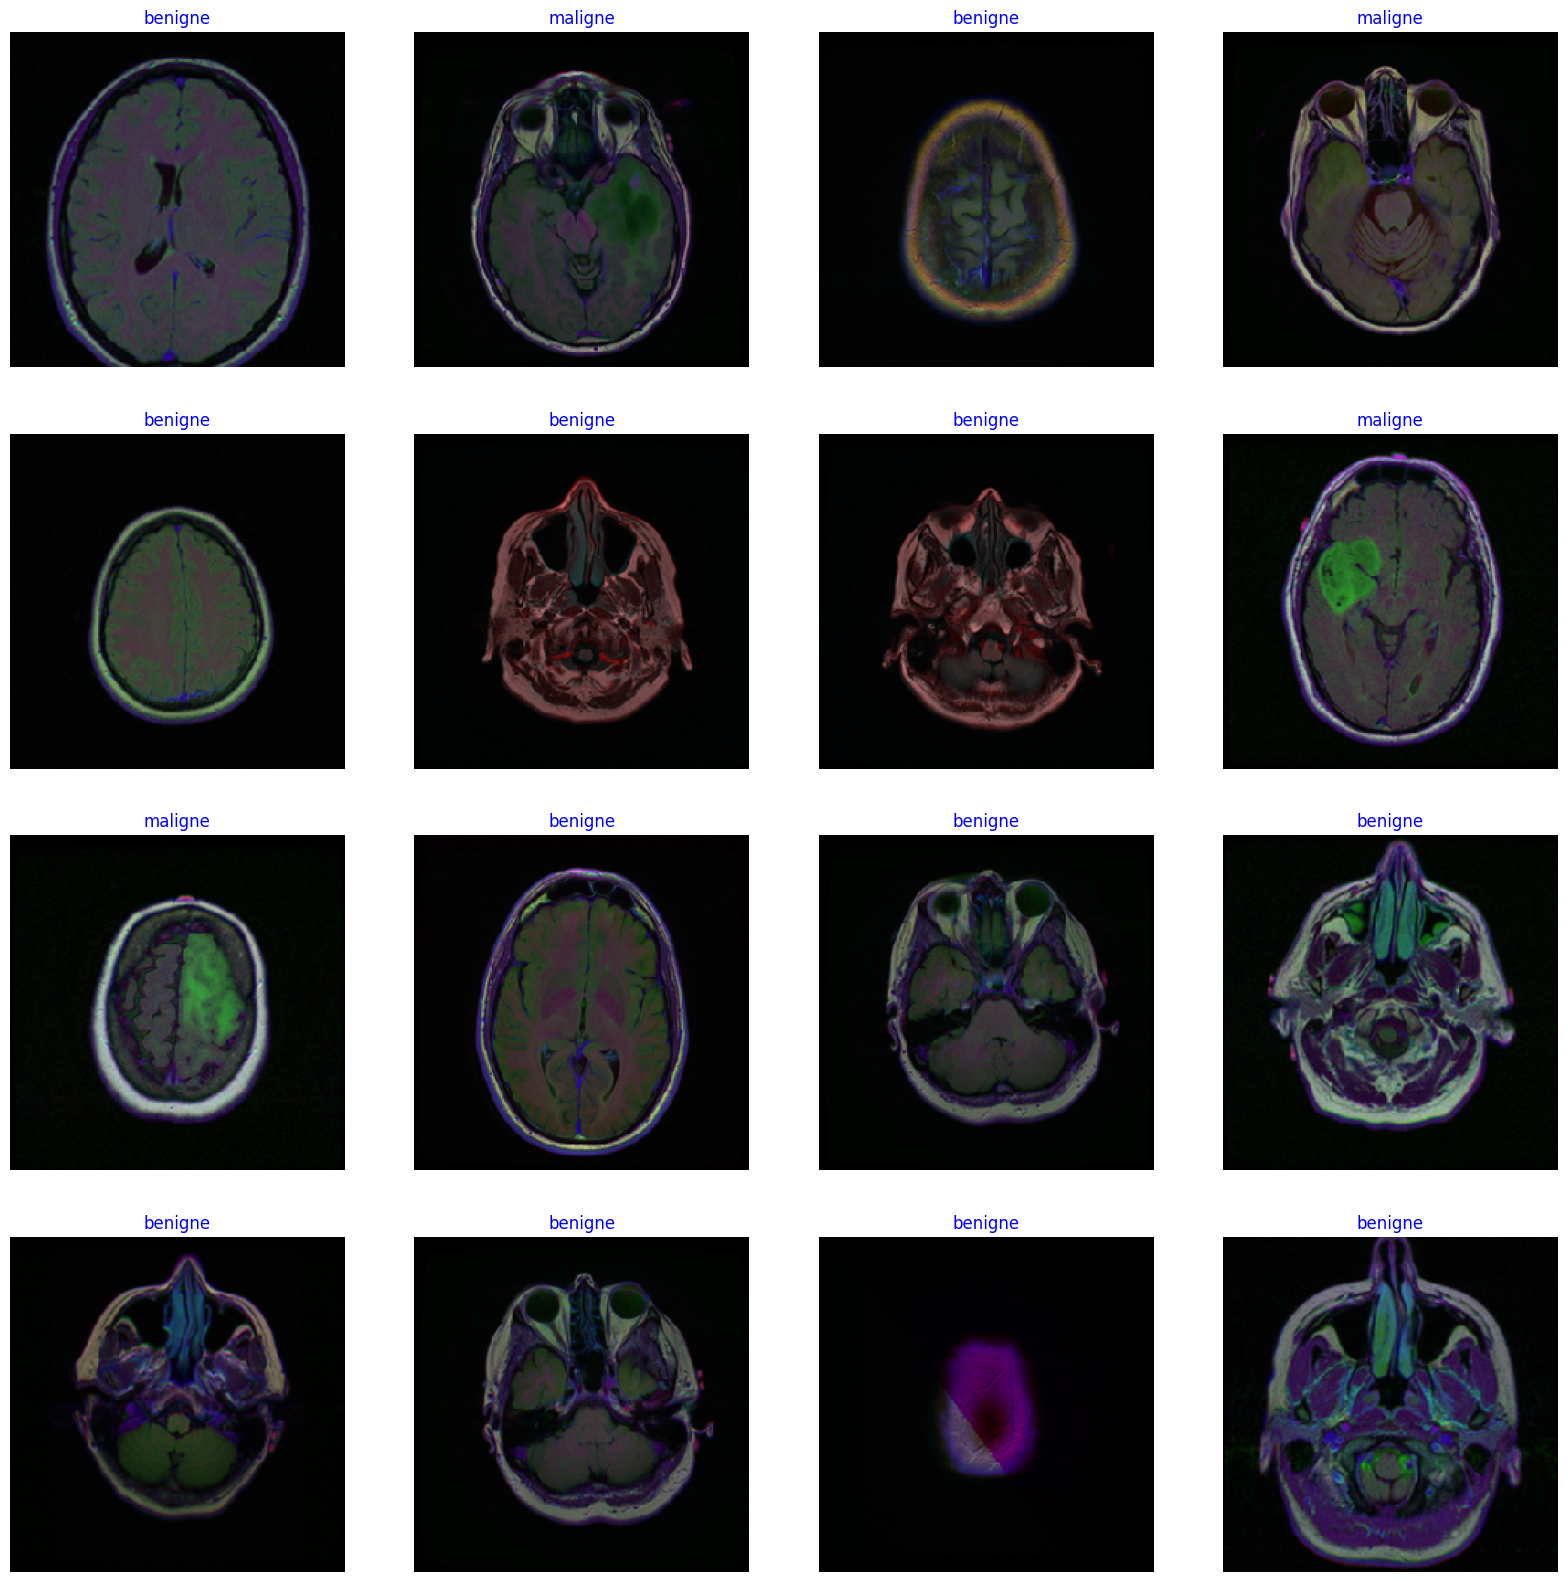

In [7]:
g_dict = train_gen.class_indices
classes = list(g_dict.keys())
images,labels = next(train_gen)
plt.figure(figsize = (20,20))
for i in range(16):
    plt.subplot(4,4,i+1)
    image = images[i]/255
    plt.imshow(image)
    index = np.argmax(labels[i])
    class_name= classes[index]
    plt.title(class_name,color='blue',fontsize=12)
    plt.axis('off')
plt.show();

### Structure du Modele

In [11]:
img_size = (224,224)
channels = 3
img_shape = (img_size[0], img_size[1], channels)

class_count = len(list(train_gen.class_indices.keys()))

model = Sequential([
    # Bloc 1
    Conv2D(filters = 64 , kernel_size = (3,3) , padding = "same" , activation = 'relu' ,input_shape=img_shape),
    Conv2D(filters = 64 , kernel_size = (3,3) , padding = "same" , activation = 'relu'),
    MaxPooling2D(2,2),
    # Bloc 2
    Conv2D(filters = 128 , kernel_size = (3,3) , padding = "same" , activation = 'relu'),
    Conv2D(filters = 128 , kernel_size = (3,3) , padding = "same" , activation = 'relu'),
    MaxPooling2D(2,2),
    # Bloc 3
    Conv2D(filters = 256 , kernel_size = (3,3) , padding = "same" , activation = 'relu'),
    Conv2D(filters = 256 , kernel_size = (3,3) , padding = "same" , activation = 'relu'),
    Conv2D(filters = 256 , kernel_size = (3,3) , padding = "same" , activation = 'relu'),
    MaxPooling2D(2,2),
    # Bloc 4
    Conv2D(filters = 512 , kernel_size = (3,3) , padding = "same" , activation = 'relu'),
    Conv2D(filters = 512 , kernel_size = (3,3) , padding = "same" , activation = 'relu'),
    Conv2D(filters = 512 , kernel_size = (3,3) , padding = "same" , activation = 'relu'),
    MaxPooling2D(2,2),
    
    Flatten(),
    
    Dense(256, activation='relu',input_dim=30),
    Dense(64,activation = 'relu'),
    Dense(class_count, activation = 'softmax')
])
model.compile(Adamax(learning_rate=0.001), loss = 'categorical_crossentropy',metrics = ['accuracy'])
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_10 (Conv2D)          (None, 224, 224, 64)      1792      
                                                                 
 conv2d_11 (Conv2D)          (None, 224, 224, 64)      36928     
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 112, 112, 64)     0         
 2D)                                                             
                                                                 
 conv2d_12 (Conv2D)          (None, 112, 112, 128)     73856     
                                                                 
 conv2d_13 (Conv2D)          (None, 112, 112, 128)     147584    
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 56, 56, 128)      0         
 2D)                                                  

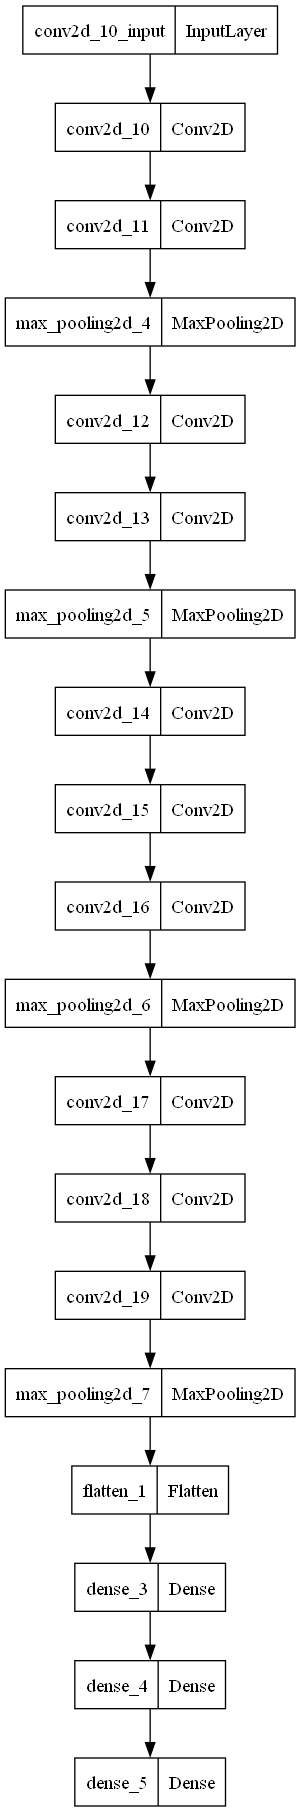

In [12]:
# plot graph
from keras.utils import plot_model
plot_model(model, to_file='naomie_cnn.png')

In [13]:
epochs = 5
history = model.fit(x=train_gen,epochs= epochs, validation_data=valid_gen,shuffle= False)

Epoch 1/5
197/197 [==============================] - 3099s 16s/step - loss: 1.1313 - accuracy: 0.7201 - val_loss: 0.5281 - val_accuracy: 0.6505
Epoch 2/5
197/197 [==============================] - 3033s 15s/step - loss: 0.4204 - accuracy: 0.7793 - val_loss: 0.4624 - val_accuracy: 0.7500
Epoch 3/5
197/197 [==============================] - 3022s 15s/step - loss: 0.3581 - accuracy: 0.8292 - val_loss: 0.4431 - val_accuracy: 0.7628
Epoch 4/5
197/197 [==============================] - 2628s 13s/step - loss: 0.2848 - accuracy: 0.8712 - val_loss: 0.4212 - val_accuracy: 0.7704
Epoch 5/5
197/197 [==============================] - 2660s 14s/step - loss: 0.2412 - accuracy: 0.8966 - val_loss: 0.5050 - val_accuracy: 0.7832


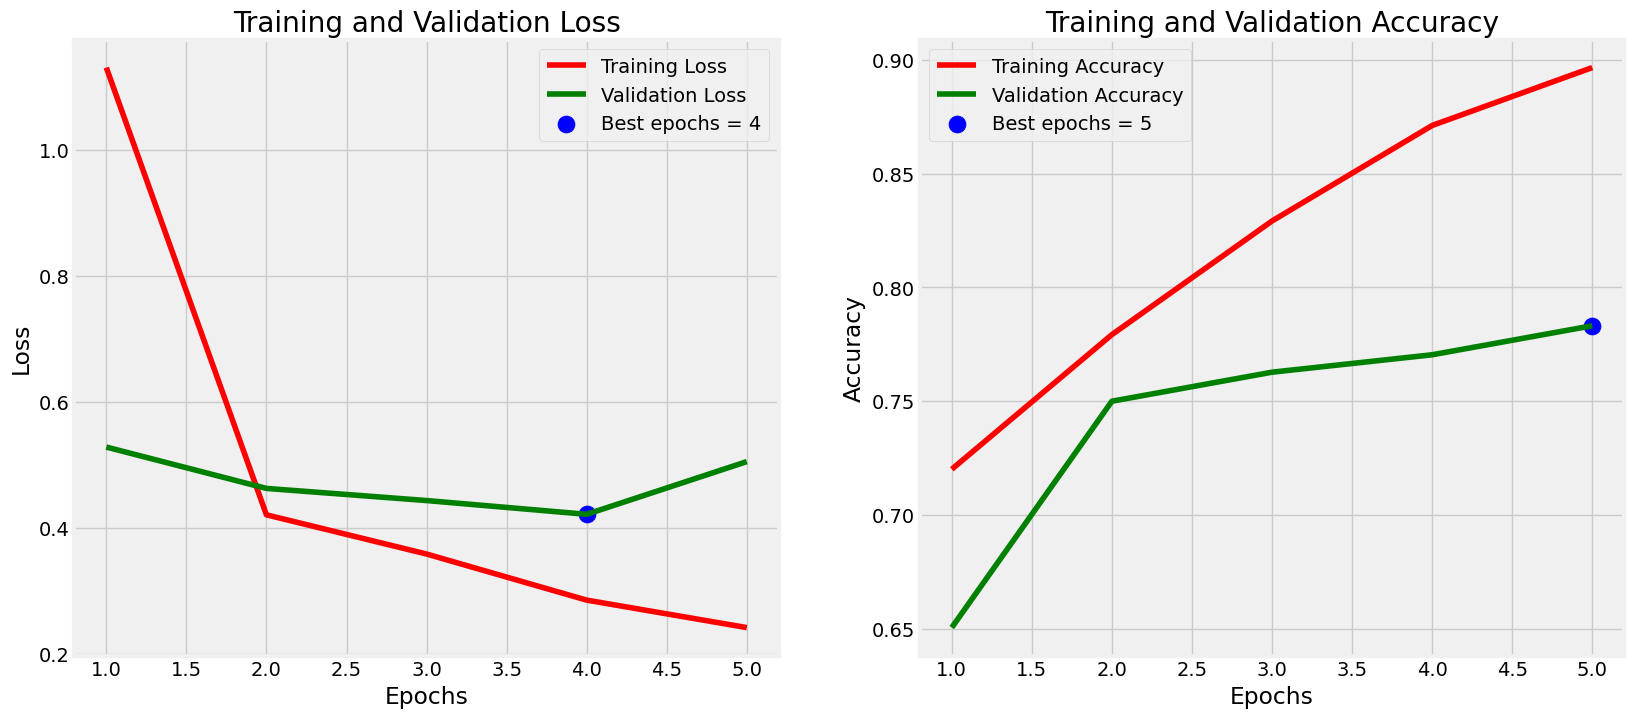

In [14]:
train_acc = history.history['accuracy']
train_loss = history.history['loss']

val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']

index_loss = np.argmin(val_loss)
val_lowest = val_loss[index_loss]

index_acc = np.argmax(val_acc)
val_highest = val_acc[index_acc]

Epochs = [i+1 for i in range(len(train_acc))]

loss_label = f'Best epochs = {str(index_loss +1)}'
acc_label = f'Best epochs = {str(index_acc + 1)}'

plt.figure(figsize= (20,8))
plt.style.use('fivethirtyeight')

plt.subplot(1,2,1)
plt.plot(Epochs , train_loss , 'r' , label = 'Training Loss')
plt.plot(Epochs , val_loss , 'g' , label = 'Validation Loss')
plt.scatter(index_loss + 1 , val_lowest , s = 150 , c = 'blue',label = loss_label)
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1,2,2)
plt.plot(Epochs , train_acc , 'r' , label = 'Training Accuracy')
plt.plot(Epochs , val_acc , 'g' , label = 'Validation Accuracy')
plt.scatter(index_acc + 1 , val_highest , s = 150 , c = 'blue',label = acc_label)
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.tight_layout
plt.show();

In [15]:
train_score = model.evaluate(train_gen ,  verbose = 1)
valid_score = model.evaluate(valid_gen ,  verbose = 1)
test_score = model.evaluate(test_gen ,  verbose = 1)

25/25 [==============================] - 89s 4s/step - loss: 0.4235 - accuracy: 0.8066


In [16]:
preds = model.predict_generator(test_gen)

y_pred = np.argmax(preds , axis = 1)
y_pred

array([0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0,
       0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1,
       0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0,
       1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0,
       0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0,
       0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1,
       0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0,
       1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0,
       0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0,
       0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1,

In [17]:
g_dict = test_gen.class_indices
classes = list(g_dict.keys())
cm = confusion_matrix(test_gen.classes, y_pred)
cm 

array([[236,  21],
       [ 55,  81]], dtype=int64)

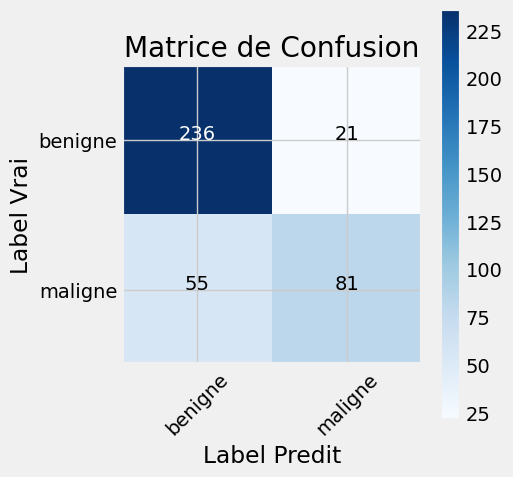

In [18]:
plt.figure(figsize= (5, 5))
plt.imshow(cm, interpolation= 'nearest', cmap= plt.cm.Blues)
plt.title('Matrice de Confusion')
plt.colorbar()

tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation= 45)
plt.yticks(tick_marks, classes)

thresh = cm.max() / 2.
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, cm[i, j], horizontalalignment= 'center', color= 'white' if cm[i, j] > thresh else 'black')

plt.tight_layout()
plt.ylabel('Label Vrai')
plt.xlabel('Label Predit')
plt.show()